In [2]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('../MFP Regular Sites 2019 - addresses2019 updated.csv')
locations = df[['latitude', 'longitude']]
data_weights = df['Average Demand per Visit']
data_stdev = df['StDev(Demand per Visit)']

max_n = len(data_stdev)
dist_types = np.asarray([.25, .3, 1-.25-.3])
print(dist_types)


print(max_n)

num_iterations = 10

[0.25 0.3  0.45]
70


Simulating B items, each associated with a generic distribution (to be filled in after)
Each item is tagged with an expected perishing date, true perishing date drawn from dist, indicator as to whether perished, indicator as to whether allocated
Sort according to perishing date and go down list, skipping what perished and what was allocated


In [7]:
def time_dist(b, n):
    val = np.random.binomial(n=1, p = min(0.03, 1/np.sqrt(n)))
    return val + (1-val)*n

In [24]:
conf_cons = 2
num_groups = np.arange(5, max_n)

data = []

for n in tqdm(num_groups):
# for n in [10]:
    n = int(n) + 5
    
    
    print('Num Locations: ' + str(n))
    num_valid = 0
    while num_valid < num_iterations:
        
        
        index = np.random.choice(max_n, n, replace=False)
        mean_size = np.asarray([dist_types * data_weights[index].to_numpy()[j] for j in range(n)])
        stdev_size = np.asarray([(dist_types**2) * data_weights[index].to_numpy()[j] for j in range(n)])
             
        max_budget = int(np.sum(mean_size))
        
        size = np.maximum(1, np.random.normal(mean_size, stdev_size))
        size = np.sum(size, axis=1)
        mean_size = np.sum(mean_size, axis=1)
        
        
        resource_perish = np.asarray([time_dist(b,n) for b in range(budget)])
        
        # Note - going to assume that time_dist is ordered so that we can allocate in decreasing order
        check_optimality = [(max_budget / np.sum(size))*np.sum(size[:(t+1)]) 
                                - np.count_nonzero([resource_perish <= t]) for t in range(n)]
        if np.min(check_optimality) < 0: # checks if B/N is feasible in hindsight
#             print('Invalid')
            continue
        else:
            num_valid += 1
#             print('Valid')
            
        # Sets up optimal solution in hindsight and lower threshold allocation
        xopt = max_budget / np.sum(size)
        x_lower = (max_budget / (mean_size*n + conf_cons / np.sqrt(n)))*(1 - conf_cons / np.sqrt(n))


        # dictionary keeping track of amount of each resource which is used and its perishing time
        resource_dict = {}
        for b in range(max_budget):
            resource_dict[str(b)] = (0, resource_perish[b])
#         print(f'Starting Resource Dictionary: {resource_dict}')
        flag = False 
        current_index = 0
        for t in range(n):
            to_allocate = size[t] * x_lower
#             print(f'Amount to allocate: {to_allocate}')
            alloc_tracker = 0
            
            
            for b in np.arange(current_index, max_budget):
                (frac, perish_time) = resource_dict[str(b)]
                current_index = b
                if perish_time >= n: # perishing in the future from this round
                    alloc_amt = min(1 - frac, to_allocate - alloc_tracker)
#                     print(f'Allocation amount: {alloc_amt}')
                    alloc_tracker += alloc_amt
                    resource_dict[str(b)] = (frac+alloc_amt, perish_time)
                if alloc_tracker >= to_allocate:
                    break
                
#             print(f'Current person resource dict: {resource_dict}')
            if alloc_tracker < to_allocate: # run out of resources
                print('Out of resources')
                flag = True
                waste = 0
                counterfactual_envy = np.abs(xopt - alloc_tracker / size[t])
                hindsight_envy = np.abs(x_lower - alloc_tracker / size[t])
                
        if flag == False: # did not run out of resources
            hindsight_envy = 0
            counterfactual_envy = np.abs(xopt - x_lower)
            waste = max_budget - np.sum([resource_dict[str(b)][0] for b in range(max_budget)])
#         print(resource_dict)
        perish_un_alloc_vec = []
        for b in range(max_budget):
            if resource_dict[str(b)][1] < n:
                perish_un_alloc_vec.append(1 - resource_dict[str(b)][0])
            else:
                perish_un_alloc_vec.append(0)
        perish_un_allocate = np.sum(perish_un_alloc_vec)

        data_dict = {'NumGroups': n, 'Norm': 'Hindsight_Envy', 'Value': hindsight_envy}
        data.append(data_dict)
        data_dict = {'NumGroups': n, 'Norm': 'Counterfactual_Envy', 'Value': counterfactual_envy}
        data.append(data_dict)
        data_dict = {'NumGroups': n, 'Norm': 'Waste', 'Value': waste}
        data.append(data_dict)
        data_dict = {'NumGroups': n, 'Norm': 'Perished_Un_Allocated', 'Value': perish_un_allocate}
        data.append(data_dict)



  0%|          | 0/65 [00:00<?, ?it/s]

Num Locations: 10


IndexError: index 1203 is out of bounds for axis 0 with size 1203

In [6]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data/single_iid.csv', index=False)
df = pd.read_csv('./data/single_iid.csv')

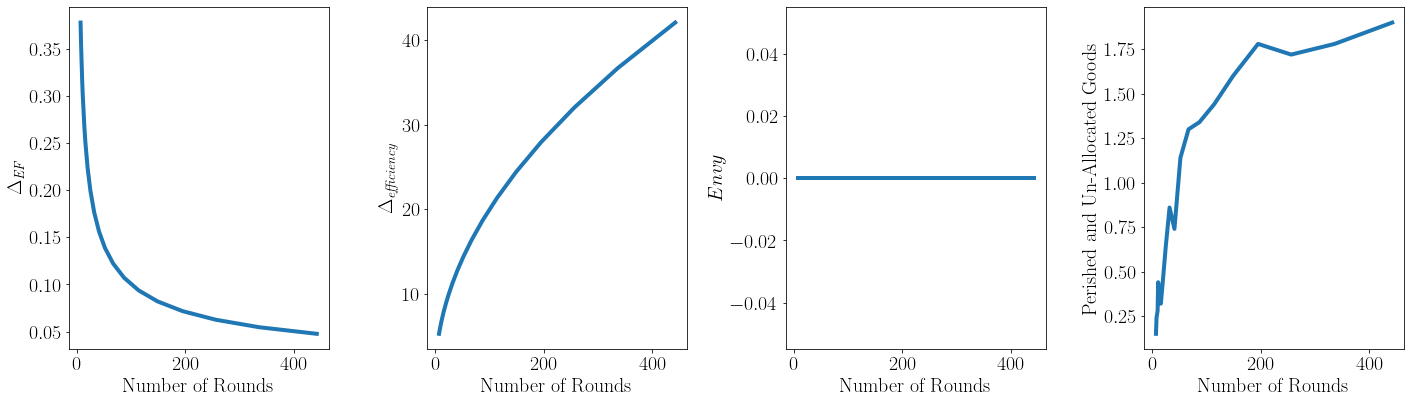

In [8]:

df.columns


plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,4, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value',
                     data=df[df.Norm == 'Counterfactual_Envy'], ax = axs[0], linewidth=4,
            ci = None)
sns.lineplot(x='NumGroups', y='Value',
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", 1),
            ci = None)

sns.lineplot(x='NumGroups', y='Value',
             data=df[df.Norm == 'Hindsight_Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", 1),
            ci = None)

sns.lineplot(x='NumGroups', y='Value',
             data=df[df.Norm == 'Perished_Un_Allocated'], ax = axs[3], linewidth=4, palette = sns.color_palette("colorblind", 1),
            ci = None)


# axs[0].get_legend().remove()
axs[0].set_ylabel('$\Delta_{\it EF}$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\Delta_{\it efficiency}$')
axs[1].set_xlabel('Number of Rounds')
# axs[1].get_legend().remove()

# axs[2].get_legend().remove()
axs[2].set_ylabel(r'$Envy$')
axs[2].set_xlabel('Number of Rounds')

axs[3].set_ylabel(r'Perished and Un-Allocated Goods')
axs[3].set_xlabel('Number of Rounds')

# 
# axs[2].legend(ncol = 1, loc= 'upper right')




plt.show()
fg.savefig('./figures/synthetic_iid_perish.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)